### 노동자 성별 예측- 노동자들의 데이터를 보고 성별을 예측하자

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline

#시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#상관관계 그래프
from pandas.plotting import scatter_matrix

#모델 검증
#K-교차검증
from sklearn.model_selection import cross_val_score #, StratifiedShuffleSplit

#데이터 샘플링-훈련/검증
from sklearn.model_selection import train_test_split
#결정트리
from sklearn.tree import DecisionTreeClassifier

# P 클래스로 보았을 때 정밀도, 재현율, F1점수 구하고 
#그 평균값으로 전체 모형의 성능을 평가
from sklearn.metrics import classification_report

#서포트 벡터 머신 - 적은 데이터
from sklearn.svm import SVC
#
#XGBoost
import xgboost as xgb
from xgboost import XGBClassifier 
from xgboost import plot_importance #피처 중요도 확인

#scaling
#표준화 : 평균 제외, 표준편차로 나누어 분산이 1이 되도록
from sklearn.preprocessing import StandardScaler
#값들을 0~1 사이에 들도록 이동, 스케일 조정
from sklearn.preprocessing import MinMaxScaler
#평균과 분산 대신 중간값 사분위값 사용, 중앙값-IQR 값 사용. 이상치 최소화
from sklearn.preprocessing import RobustScaler

#결정트리의 앙상블?
from sklearn.ensemble import RandomForestClassifier
#로지스틱 회귀
from sklearn.linear_model import LogisticRegression
#K-최근접 이웃
from sklearn.neighbors import KNeighborsClassifier
#선형회귀
from sklearn.linear_model import LinearRegression

#K-fold 교차 검증- 데이터 수 적을 경우?
from sklearn.model_selection import KFold


#모델 세부 튜닝
#그리드 탐색
from sklearn.model_selection import GridSearchCV



#예측한 데이터와 실제 값으로 예측 오차 계산
from sklearn.metrics import mean_squared_error

###샘플링 알고리즘
#under sampling
from imblearn.under_sampling import *
from imblearn.under_sampling import TomekLinks
#over sampling
from imblearn.over_sampling import *
#복합 샘플링
from imblearn.combine import *
from imblearn.combine import SMOTETomek

import matplotlib.font_manager as fm
from lightgbm import LGBMClassifier


#warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
### 그래프 한글 깨짐 해결
import platform
platform.system()
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) #마이너스폰트 설정
#plt.rc('font', family='AppleGothic') - Darwin : Mac  

In [3]:
train = pd.read_csv('human.csv', encoding='cp949').set_index('아이디')
test = pd.read_csv('human_new.csv', encoding='cp949').set_index('아이디')
train.head()

,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,성별,자본 이득,자본 손실,주당 시간,모국
아이디,,,,,,,,,,,,,,
H20001,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
H20002,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
H20003,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
H20004,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
H20005,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [4]:
mdf = train.copy()

In [5]:
mdf.isnull().sum()

나이           0
노동 계급     1836
fnlwgt       0
학력           0
교육 수         0
혼인 상태        0
직업        1843
관계           0
인종           0
성별           0
자본 이득        0
자본 손실        0
주당 시간        0
모국         583
dtype: int64

In [6]:
#결측값 처리 
from sklearn.impute import SimpleImputer
imputer_nul = SimpleImputer(strategy="most_frequent")
nul =['노동 계급','직업','모국']
imputer_nul.fit(mdf[nul])

SimpleImputer(strategy='most_frequent')

In [7]:
x = imputer_nul.transform(mdf[nul])
mdf[nul] =x
mdf.isnull().sum()

나이        0
노동 계급     0
fnlwgt    0
학력        0
교육 수      0
혼인 상태     0
직업        0
관계        0
인종        0
성별        0
자본 이득     0
자본 손실     0
주당 시간     0
모국        0
dtype: int64

In [8]:
# 결혼 변수 추가
mdf['혼인 상태'] = mdf['혼인 상태'].str.lstrip()
mdf['혼인 상태'].value_counts()   

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: 혼인 상태, dtype: int64

In [9]:
str1 = 'Never-married','Divorced'
def marr(x):
    결혼 = ''
    if x in str1: 결혼 = '무'
    else: 결혼 = '유'
    return 결혼

In [10]:
mdf['결혼'] = mdf['혼인 상태'].apply(lambda x : marr(x))

In [11]:
#mdf['자본합'] = mdf['자본 손실']+mdf['자본 이득']

In [12]:
spo1 = 'Married-AF-spouse'
spo2 = 'Never-married', 'Divorced', 'Separated', 'Widowed'
def spouse(s):
    배우자=''
    if s in spo1 : 배우자 = '군인'
    elif s in spo2 :  배우자 = '무'
    else: 배우자 = '일반'
    return 배우자

In [13]:
mdf['배우자'] =mdf['혼인 상태'].apply(lambda s: spouse(s))

In [14]:
# 컬럼 drop
mdf = mdf.drop(['fnlwgt', '학력','자본 손실','자본 이득'], axis=1)
mdf.head()

,나이,노동 계급,교육 수,혼인 상태,직업,관계,인종,성별,주당 시간,모국,결혼,배우자
아이디,,,,,,,,,,,,
H20001,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,무,무
H20002,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,유,일반
H20003,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,무,무
H20004,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,유,일반
H20005,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,유,일반


In [15]:
mdf.head()

,나이,노동 계급,교육 수,혼인 상태,직업,관계,인종,성별,주당 시간,모국,결혼,배우자
아이디,,,,,,,,,,,,
H20001,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,무,무
H20002,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,유,일반
H20003,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,무,무
H20004,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,유,일반
H20005,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,유,일반


In [16]:
df_jobs = pd.get_dummies(mdf['직업'])

In [17]:
mdf = pd.concat([mdf,df_jobs], axis=1)

In [18]:
mdf = mdf.drop(['직업'], axis=1)

In [19]:
mdf.head()

,나이,노동 계급,교육 수,혼인 상태,관계,인종,성별,주당 시간,모국,결혼,...,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
아이디,,,,,,,,,,,,,,,,,,,,,
H20001,39,State-gov,13,Never-married,Not-in-family,White,Male,40,United-States,무,...,0,0,0,0,0,0,0,0,0,0
H20002,50,Self-emp-not-inc,13,Married-civ-spouse,Husband,White,Male,13,United-States,유,...,0,0,0,0,0,0,0,0,0,0
H20003,38,Private,9,Divorced,Not-in-family,White,Male,40,United-States,무,...,0,1,0,0,0,0,0,0,0,0
H20004,53,Private,7,Married-civ-spouse,Husband,Black,Male,40,United-States,유,...,0,1,0,0,0,0,0,0,0,0
H20005,28,Private,13,Married-civ-spouse,Wife,Black,Female,40,Cuba,유,...,0,0,0,0,0,1,0,0,0,0


In [20]:
#object, num 구분
obj = mdf.dtypes[mdf.dtypes == 'object'].index
num = mdf.dtypes[mdf.dtypes != 'object'].index
display(obj)
display(num)

Index(['노동 계급', '혼인 상태', '관계', '인종', '성별', '모국', '결혼', '배우자'], dtype='object')

Index(['나이', '교육 수', '주당 시간', ' Adm-clerical', ' Armed-Forces',
       ' Craft-repair', ' Exec-managerial', ' Farming-fishing',
       ' Handlers-cleaners', ' Machine-op-inspct', ' Other-service',
       ' Priv-house-serv', ' Prof-specialty', ' Protective-serv', ' Sales',
       ' Tech-support', ' Transport-moving'],
      dtype='object')

In [21]:
mdf[obj] = mdf[obj].apply(lambda x: x.astype('category').cat.codes)

<AxesSubplot:>

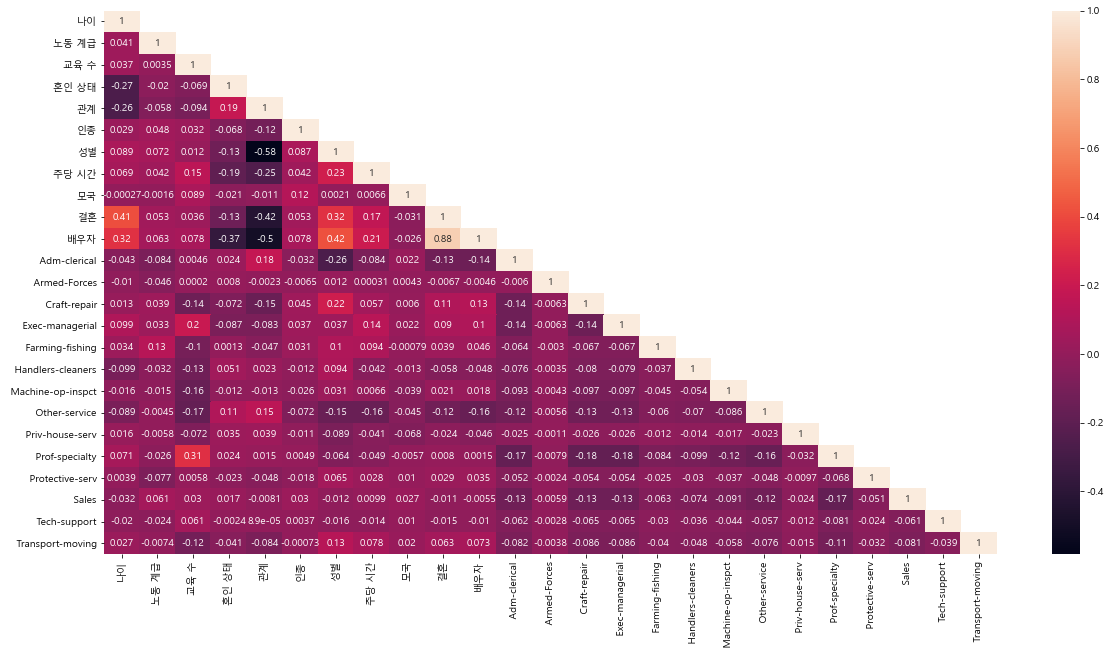

In [22]:
## 성별과 각 컬럼 간의 연관성 확인?
corr=mdf.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corr, mask=mask, vmax=1.,annot=True)

## 참고 사이트
# https://www.kaggle.com/fkstepz/step-by-step-predict-bike-sharing-demand

In [23]:
mdf.describe()

,나이,노동 계급,교육 수,혼인 상태,관계,인종,성별,주당 시간,모국,결혼,...,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,...,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.0000,32561.000000
mean,38.581647,3.094438,10.080679,2.611836,1.446362,3.665858,0.669205,40.437456,36.417155,0.535457,...,0.030527,0.042075,0.061485,0.101195,0.004576,0.183747,0.019932,0.112097,0.0285,0.049046
std,13.640433,1.107194,2.572720,1.506222,1.606771,0.848806,0.470506,12.347429,6.056047,0.498749,...,0.172036,0.200763,0.240221,0.301591,0.067492,0.387284,0.139768,0.315491,0.1664,0.215968
min,17.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
25%,28.000000,3.000000,9.000000,2.000000,0.000000,4.000000,0.000000,40.000000,38.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
50%,37.000000,3.000000,10.000000,2.000000,1.000000,4.000000,1.000000,40.000000,38.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
75%,48.000000,3.000000,12.000000,4.000000,3.000000,4.000000,1.000000,45.000000,38.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
max,90.000000,7.000000,16.000000,6.000000,5.000000,4.000000,1.000000,99.000000,40.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000


<AxesSubplot:xlabel='성별', ylabel='주당 시간'>

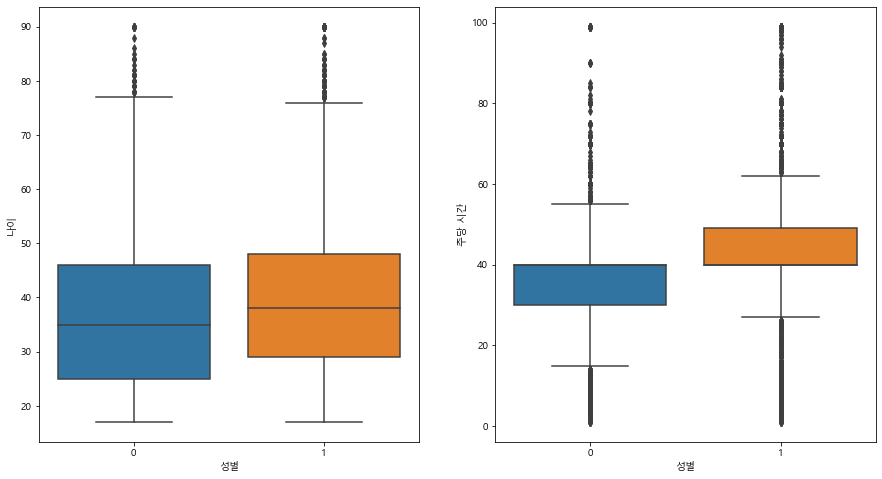

In [24]:
## 연관성 & 이상치 확인 가능
f, axes = plt.subplots(ncols=2, figsize=(15,8))
sns.boxplot(x="성별", y= "나이", data=mdf, ax=axes[0])
sns.boxplot(x="성별", y= "주당 시간", data=mdf, ax=axes[1])
#plt.show()

In [25]:
###이상치 제거

In [26]:
'''
Q1=mdf['나이'].quantile(.25)
Q3 =mdf['나이'].quantile(.75)
IQR = Q3-Q1

print("Q1 =",Q1)
print("Q3 =",Q3)
print("IQR =",IQR)
print("max =",Q3+1.5*IQR)
print("min =",Q1-(1.5*IQR))
'''

'\nQ1=mdf[\'나이\'].quantile(.25)\nQ3 =mdf[\'나이\'].quantile(.75)\nIQR = Q3-Q1\n\nprint("Q1 =",Q1)\nprint("Q3 =",Q3)\nprint("IQR =",IQR)\nprint("max =",Q3+1.5*IQR)\nprint("min =",Q1-(1.5*IQR))\n'

In [27]:
#outliers = mdf['나이'], mdf['주당 시간']
q1 = mdf['나이'].quantile(0.25)
q3 = mdf['나이'].quantile(0.75)
IQR = q3 - q1
old = mdf[(mdf['나이'] < (q1 - 1.5 * IQR)) | (mdf['나이'] > (q3 + 1.5 * IQR))]
old

,나이,노동 계급,교육 수,혼인 상태,관계,인종,성별,주당 시간,모국,결혼,...,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
아이디,,,,,,,,,,,,,,,,,,,,,
H20075,79,3,10,2,2,4,1,20,38,1,...,0,0,0,0,0,1,0,0,0,0
H20223,90,3,9,4,1,2,1,40,38,0,...,0,0,0,1,0,0,0,0,0,0
H20431,80,3,9,6,1,4,1,24,38,1,...,0,0,0,0,0,1,0,0,0,0
H20919,81,5,9,2,0,4,1,30,38,1,...,0,0,0,0,0,0,0,0,0,0
H21041,90,3,9,4,1,4,0,40,38,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H52278,90,3,9,6,4,4,0,25,38,1,...,0,0,0,0,0,0,0,0,0,0
H52368,90,1,4,2,0,4,1,40,38,1,...,0,0,0,0,0,0,1,0,0,0
H52460,85,3,13,2,0,4,1,3,30,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# IQR 기준 이상치 행 지우기
mdf = mdf.drop(old.index, axis=0)
mdf.shape

(32418, 25)

In [29]:
# 컬럼 drop
#mdf = mdf.drop(['모국', '노동 계급', '자본 손실','자본 이득'], axis=1)
#mdf.head()

array([[<AxesSubplot:title={'center':'나이'}>,
        <AxesSubplot:title={'center':'노동 계급'}>,
        <AxesSubplot:title={'center':'교육 수'}>,
        <AxesSubplot:title={'center':'혼인 상태'}>,
        <AxesSubplot:title={'center':'관계'}>],
       [<AxesSubplot:title={'center':'인종'}>,
        <AxesSubplot:title={'center':'성별'}>,
        <AxesSubplot:title={'center':'주당 시간'}>,
        <AxesSubplot:title={'center':'모국'}>,
        <AxesSubplot:title={'center':'결혼'}>],
       [<AxesSubplot:title={'center':'배우자'}>,
        <AxesSubplot:title={'center':' Adm-clerical'}>,
        <AxesSubplot:title={'center':' Armed-Forces'}>,
        <AxesSubplot:title={'center':' Craft-repair'}>,
        <AxesSubplot:title={'center':' Exec-managerial'}>],
       [<AxesSubplot:title={'center':' Farming-fishing'}>,
        <AxesSubplot:title={'center':' Handlers-cleaners'}>,
        <AxesSubplot:title={'center':' Machine-op-inspct'}>,
        <AxesSubplot:title={'center':' Other-service'}>,
        <AxesSubplot:titl

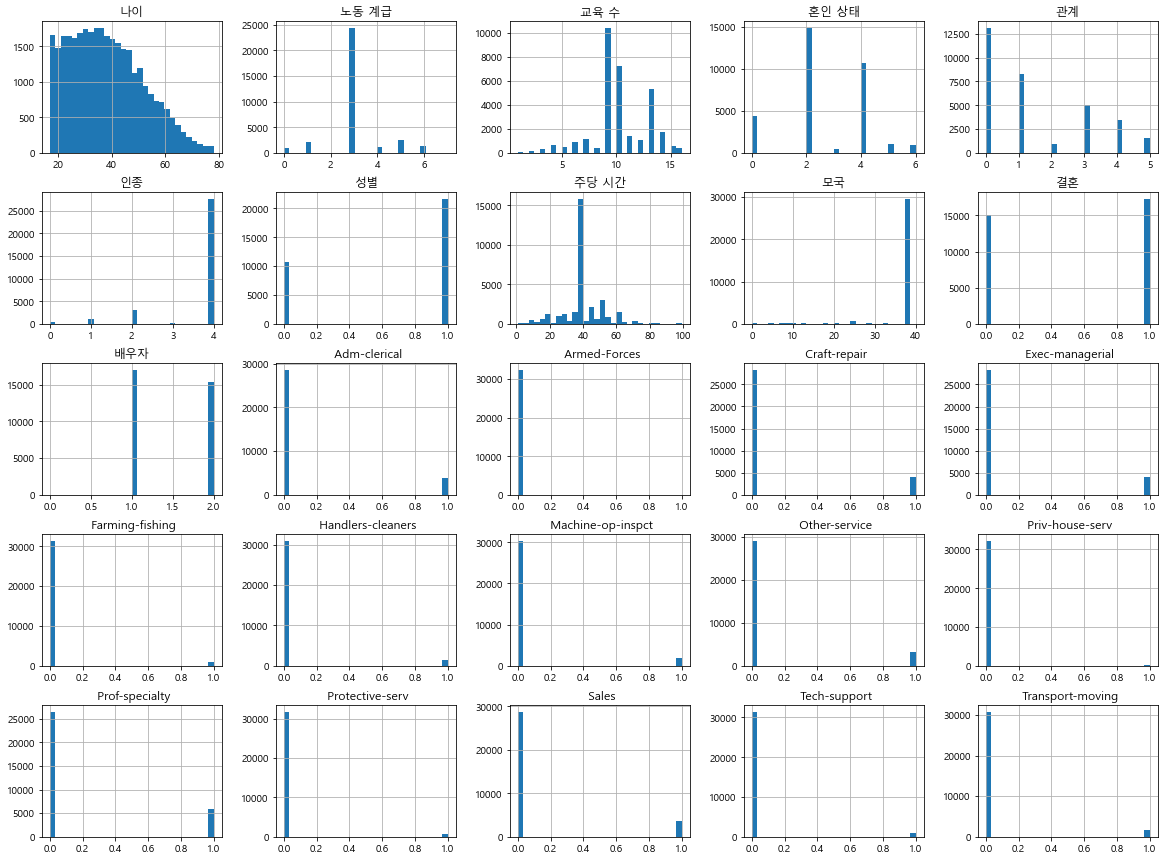

In [30]:
mdf.hist(bins=30, figsize=(20,15))

In [31]:
'''
f, ax = plt.subplots(1,2,figsize=(10,5))

# 남녀 빈도 체크
gender_freq = mdf.성별.value_counts().sort_values()
gender_freq.plot.pie(explode=[0,0.05], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('남녀 비율')#, fontproperties=font_prop)
ax[0].set_ylabel('')

# 
sns.countplot('성별', data=mdf, ax=ax[1])
ax[1].set_title('결혼') #, fontproperties=font_prop)
plt.show()
#0 f, 1 m
'''

"\nf, ax = plt.subplots(1,2,figsize=(10,5))\n\n# 남녀 빈도 체크\ngender_freq = mdf.성별.value_counts().sort_values()\ngender_freq.plot.pie(explode=[0,0.05], autopct='%1.1f%%', ax=ax[0], shadow=True)\nax[0].set_title('남녀 비율')#, fontproperties=font_prop)\nax[0].set_ylabel('')\n\n# \nsns.countplot('성별', data=mdf, ax=ax[1])\nax[1].set_title('결혼') #, fontproperties=font_prop)\nplt.show()\n#0 f, 1 m\n"

RobustScaler:
모든 특성들이 같은 크기를 갖는다는 점에서 StandardScaler와 비슷하지만, 평균과 분산 대신 median과 quartile을 사용합니다.
RobustScaler는 이상치에 영향을 받지 않습니다

In [32]:
mdf.shape

(32418, 25)

In [33]:
mdf.head()

,나이,노동 계급,교육 수,혼인 상태,관계,인종,성별,주당 시간,모국,결혼,...,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
아이디,,,,,,,,,,,,,,,,,,,,,
H20001,39,6,13,4,1,4,1,40,38,0,...,0,0,0,0,0,0,0,0,0,0
H20002,50,5,13,2,0,4,1,13,38,1,...,0,0,0,0,0,0,0,0,0,0
H20003,38,3,9,0,1,4,1,40,38,0,...,0,1,0,0,0,0,0,0,0,0
H20004,53,3,7,2,0,2,1,40,38,1,...,0,1,0,0,0,0,0,0,0,0
H20005,28,3,13,2,5,2,0,40,4,1,...,0,0,0,0,0,1,0,0,0,0


In [34]:
from sklearn.model_selection import train_test_split  
X = mdf.drop(['성별'], axis=1) 
Y = mdf['성별']                    
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

### pipeline

In [35]:
pipe_tree = Pipeline([('scaler', MinMaxScaler()), ('tree',DecisionTreeClassifier())])

In [36]:
pipe_tree.fit(X_train, y_train).score(X_test, y_test)

0.8074028377544725

In [37]:
pipe_svm = Pipeline([('scaler', MinMaxScaler()), ('svm',SVC())])

In [38]:
pipe_svm.fit(X_train, y_train).score(X_test, y_test)

0.8302282541640963

In [39]:
pipe_xgb = Pipeline([('scaler', MinMaxScaler()), ('xgb',XGBClassifier())])

In [40]:
#pipe_xgb.fit(X_train, y_train).score(X_test, y_test)

###########################################################################################

In [41]:
#XGB model

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

params = {'max_depth':4,
          'eta':0.1,
          'objective':'binary:logistic',
          'eval_metric':'logloss',
          'early_stoppings':100
         }
num_rounds = 400

In [42]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기
wlist = [(dtrain, 'train'),(dtest, 'eval')]
# 하이퍼 파라미터와 early stoppinig 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[16:43:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stoppings } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.64244	eval-logloss:0.64263
[1]	train-logloss:0.60071	eval-logloss:0.60125
[2]	train-logloss:0.56593	eval-logloss:0.56652
[3]	train-logloss:0.53647	eval-logloss:0.53720
[4]	train-logloss:0.51110	eval-logloss:0.51228
[5]	train-logloss:0.48921	eval-logloss:0.49056
[6]	train-logloss:0.47022	eval-logloss:0.47171
[7]	train-logloss:0.45347	eval-logloss:0.45530
[8]	train-logloss:0.43879	eval-logloss:0.44091
[9]	train-logloss:0.42585	eval-logloss:0.42784
[10]	train-logloss:0.41406	eval-logloss:0.41638
[11]	train-logloss:0.40361	eval-logloss:0.40616
[12]	train-logloss:0.39403	eval-logloss:0

[162]	train-logloss:0.27731	eval-logloss:0.29505
[163]	train-logloss:0.27722	eval-logloss:0.29503
[164]	train-logloss:0.27717	eval-logloss:0.29499
[165]	train-logloss:0.27691	eval-logloss:0.29488
[166]	train-logloss:0.27687	eval-logloss:0.29492
[167]	train-logloss:0.27665	eval-logloss:0.29484
[168]	train-logloss:0.27655	eval-logloss:0.29485
[169]	train-logloss:0.27649	eval-logloss:0.29484
[170]	train-logloss:0.27637	eval-logloss:0.29478
[171]	train-logloss:0.27627	eval-logloss:0.29475
[172]	train-logloss:0.27623	eval-logloss:0.29473
[173]	train-logloss:0.27606	eval-logloss:0.29468
[174]	train-logloss:0.27591	eval-logloss:0.29457
[175]	train-logloss:0.27584	eval-logloss:0.29461
[176]	train-logloss:0.27576	eval-logloss:0.29457
[177]	train-logloss:0.27566	eval-logloss:0.29448
[178]	train-logloss:0.27555	eval-logloss:0.29450
[179]	train-logloss:0.27552	eval-logloss:0.29449
[180]	train-logloss:0.27544	eval-logloss:0.29456
[181]	train-logloss:0.27529	eval-logloss:0.29451
[182]	train-logloss:

[330]	train-logloss:0.26406	eval-logloss:0.29404
[331]	train-logloss:0.26399	eval-logloss:0.29402
[332]	train-logloss:0.26397	eval-logloss:0.29404
[333]	train-logloss:0.26396	eval-logloss:0.29404
[334]	train-logloss:0.26387	eval-logloss:0.29404
[335]	train-logloss:0.26379	eval-logloss:0.29406
[336]	train-logloss:0.26376	eval-logloss:0.29408
[337]	train-logloss:0.26369	eval-logloss:0.29408
[338]	train-logloss:0.26361	eval-logloss:0.29405
[339]	train-logloss:0.26354	eval-logloss:0.29406
[340]	train-logloss:0.26349	eval-logloss:0.29408
[341]	train-logloss:0.26338	eval-logloss:0.29408
[342]	train-logloss:0.26334	eval-logloss:0.29406
[343]	train-logloss:0.26330	eval-logloss:0.29407
[344]	train-logloss:0.26325	eval-logloss:0.29411
[345]	train-logloss:0.26311	eval-logloss:0.29406
[346]	train-logloss:0.26307	eval-logloss:0.29408
[347]	train-logloss:0.26299	eval-logloss:0.29410
[348]	train-logloss:0.26296	eval-logloss:0.29412
[349]	train-logloss:0.26290	eval-logloss:0.29409
[350]	train-logloss:

In [43]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

preds = [1 if x > 0.5 else 0 for x in pred_probs]


predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨
[1.    1.    1.    1.    0.598 1.    1.    1.    1.    0.527]


In [44]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [45]:
get_clf_eval(y_test, preds)

오차행렬
[[2128  557]
 [ 710 4710]]
정확도: 0.8437, 정밀도: 0.8942, 재현율: 0.8690


############################# 데이터 불균형 

In [46]:
#성별 불균형 확인
mdf['성별'].value_counts()

1    21690
0    10728
Name: 성별, dtype: int64

In [47]:
X_sm, Y_sm = SMOTETomek().fit_sample(X_train, y_train)
sample_tree = DecisionTreeClassifier(max_depth=14, random_state=0)
sample_tree.fit(X_sm, Y_sm)
y_pred_sp = sample_tree.predict(X_test)
print(classification_report(y_test, y_pred_sp))


              precision    recall  f1-score   support

           0       0.68      0.89      0.77      2685
           1       0.93      0.79      0.86      5420

    accuracy                           0.82      8105
   macro avg       0.81      0.84      0.81      8105
weighted avg       0.85      0.82      0.83      8105



In [48]:
'''
X_sm, Y_sm = SMOTETomek().fit_sample(X_train, y_train)
sample_random = RandomForestClassifier(max_depth=12, random_state=0)
sample_random.fit(X_sm, Y_sm)
Y_pred_spran = sample_random.predict(X_test)
print(classification_report(y_test, Y_pred_spran))
'''

'\nX_sm, Y_sm = SMOTETomek().fit_sample(X_train, y_train)\nsample_random = RandomForestClassifier(max_depth=12, random_state=0)\nsample_random.fit(X_sm, Y_sm)\nY_pred_spran = sample_random.predict(X_test)\nprint(classification_report(y_test, Y_pred_spran))\n'

In [49]:
X_to, Y_to = TomekLinks().fit_sample(X_train, y_train)
under_random =RandomForestClassifier(max_depth=6, random_state=0)
under_random.fit(X_to, Y_to)
Y_pred_random = under_random.predict(X_test)
print(classification_report(y_test, Y_pred_random))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77      2685
           1       0.91      0.83      0.87      5420

    accuracy                           0.83      8105
   macro avg       0.81      0.83      0.82      8105
weighted avg       0.84      0.83      0.84      8105



In [50]:
'''
X_to, Y_to = TomekLinks().fit_sample(X_train, y_train) #under-Sampling
under_tree = DecisionTreeClassifier(max_depth=8, random_state=0)
under_tree.fit(X_to, Y_to)
Y_pred_un = under_tree.predict(X_test)
print(classification_report(y_test, Y_pred_un))
'''

'\nX_to, Y_to = TomekLinks().fit_sample(X_train, y_train) #under-Sampling\nunder_tree = DecisionTreeClassifier(max_depth=8, random_state=0)\nunder_tree.fit(X_to, Y_to)\nY_pred_un = under_tree.predict(X_test)\nprint(classification_report(y_test, Y_pred_un))\n'

In [51]:
y_train.value_counts()

1    16270
0     8043
Name: 성별, dtype: int64

In [52]:
Y_to.value_counts()

1    15410
0     8043
Name: 성별, dtype: int64

In [53]:
#데이터 나누기 - 
X_train, X_test, y_train, y_test = train_test_split(X_to, Y_to, test_size=0.25, random_state=0)
print(X.shape, X_to.shape, X_train.shape, X_test.shape)

(32418, 24) (23453, 24) (17589, 24) (5864, 24)


In [54]:
dec_tree = DecisionTreeClassifier(max_depth=8, random_state=0)

dec_tree.fit(X_train, y_train)
print("훈련 세트 정확도: {:.3f}".format(dec_tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(dec_tree.score(X_test, y_test)))

훈련 세트 정확도: 0.852
테스트 세트 정확도: 0.844


In [55]:
'''
svm = SVC(C=100)
svm.fit(X_train, y_train).score(X_test, y_test)
print("훈련 세트 정확도: {:.3f}".format(svm.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(svm.score(X_test, y_test)))
'''

'\nsvm = SVC(C=100)\nsvm.fit(X_train, y_train).score(X_test, y_test)\nprint("훈련 세트 정확도: {:.3f}".format(svm.score(X_train, y_train)))\nprint("테스트 세트 정확도: {:.3f}".format(svm.score(X_test, y_test)))\n'

##########################################new xgb

In [56]:
import xgboost
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [57]:
params = {'max_depth':2,
          'eta':0.1,
          'objective':'binary:logistic',
          'eval_metric':'logloss',
          'early_stoppings':100
         }
num_rounds = 200

In [58]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기
wlist = [(dtrain, 'train'),(dtest, 'eval')]
# 하이퍼 파라미터와 early stoppinig 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[16:43:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stoppings } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.64551	eval-logloss:0.64476
[1]	train-logloss:0.60652	eval-logloss:0.60516
[2]	train-logloss:0.57408	eval-logloss:0.57222
[3]	train-logloss:0.54673	eval-logloss:0.54445
[4]	train-logloss:0.52297	eval-logloss:0.52011
[5]	train-logloss:0.50258	eval-logloss:0.49940
[6]	train-logloss:0.48470	eval-logloss:0.48104
[7]	train-logloss:0.46909	eval-logloss:0.46519
[8]	train-logloss:0.45535	eval-logloss:0.45106
[9]	train-logloss:0.44315	eval-logloss:0.43849
[10]	train-logloss:0.43223	eval-logloss:0.42738
[11]	train-logloss:0.42240	eval-logloss:0.41796
[12]	train-logloss:0.41364	eval-logloss:0

[162]	train-logloss:0.27665	eval-logloss:0.27387
[163]	train-logloss:0.27652	eval-logloss:0.27373
[164]	train-logloss:0.27644	eval-logloss:0.27359
[165]	train-logloss:0.27638	eval-logloss:0.27355
[166]	train-logloss:0.27629	eval-logloss:0.27344
[167]	train-logloss:0.27623	eval-logloss:0.27338
[168]	train-logloss:0.27617	eval-logloss:0.27337
[169]	train-logloss:0.27605	eval-logloss:0.27337
[170]	train-logloss:0.27596	eval-logloss:0.27330
[171]	train-logloss:0.27588	eval-logloss:0.27324
[172]	train-logloss:0.27581	eval-logloss:0.27317
[173]	train-logloss:0.27575	eval-logloss:0.27318
[174]	train-logloss:0.27570	eval-logloss:0.27309
[175]	train-logloss:0.27560	eval-logloss:0.27298
[176]	train-logloss:0.27552	eval-logloss:0.27288
[177]	train-logloss:0.27547	eval-logloss:0.27287
[178]	train-logloss:0.27536	eval-logloss:0.27281
[179]	train-logloss:0.27531	eval-logloss:0.27275
[180]	train-logloss:0.27523	eval-logloss:0.27267
[181]	train-logloss:0.27516	eval-logloss:0.27266
[182]	train-logloss:

In [59]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

preds = [1 if x > 0.5 else 0 for x in pred_probs]

predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨
[0.684 0.074 1.    1.    0.061 0.337 0.999 1.    0.999 0.482]


In [60]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [61]:
get_clf_eval(y_test, preds)

오차행렬
[[1746  235]
 [ 602 3281]]
정확도: 0.8573, 정밀도: 0.9332, 재현율: 0.8450


In [62]:
mdf.head()

,나이,노동 계급,교육 수,혼인 상태,관계,인종,성별,주당 시간,모국,결혼,...,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
아이디,,,,,,,,,,,,,,,,,,,,,
H20001,39,6,13,4,1,4,1,40,38,0,...,0,0,0,0,0,0,0,0,0,0
H20002,50,5,13,2,0,4,1,13,38,1,...,0,0,0,0,0,0,0,0,0,0
H20003,38,3,9,0,1,4,1,40,38,0,...,0,1,0,0,0,0,0,0,0,0
H20004,53,3,7,2,0,2,1,40,38,1,...,0,1,0,0,0,0,0,0,0,0
H20005,28,3,13,2,5,2,0,40,4,1,...,0,0,0,0,0,1,0,0,0,0


#################################################### 검증 파일

In [63]:
test.head()

,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,자본 이득,자본 손실,주당 시간,모국
아이디,,,,,,,,,,,,,
H00001,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,0,0,40,United-States
H00002,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,0,0,50,United-States
H00003,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,0,0,40,United-States
H00004,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,7688,0,40,United-States
H00005,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,0,0,30,United-States


In [64]:
ndf = test.copy()
ndf.head()

,나이,노동 계급,fnlwgt,학력,교육 수,혼인 상태,직업,관계,인종,자본 이득,자본 손실,주당 시간,모국
아이디,,,,,,,,,,,,,
H00001,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,0,0,40,United-States
H00002,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,0,0,50,United-States
H00003,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,0,0,40,United-States
H00004,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,7688,0,40,United-States
H00005,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,0,0,30,United-States


In [65]:
ndf.isnull().sum()

나이          0
노동 계급     963
fnlwgt      0
학력          0
교육 수        0
혼인 상태       0
직업        966
관계          0
인종          0
자본 이득       0
자본 손실       0
주당 시간       0
모국        274
dtype: int64

In [66]:
from sklearn.impute import SimpleImputer
imputer_con = SimpleImputer(strategy="most_frequent")  
con = ['노동 계급', '학력', '혼인 상태', '직업', '관계', '인종', '모국']
imputer_con.fit(ndf[con])

SimpleImputer(strategy='most_frequent')

In [67]:
x = imputer_con.transform(ndf[con])
ndf[con] =x

In [68]:
# 결혼 변수 추가
ndf['혼인 상태'] = ndf['혼인 상태'].str.lstrip()
ndf['혼인 상태'].value_counts()   

Married-civ-spouse       7403
Never-married            5434
Divorced                 2190
Widowed                   525
Separated                 505
Married-spouse-absent     210
Married-AF-spouse          14
Name: 혼인 상태, dtype: int64

In [69]:
str1 = 'Never-married','Divorced'
def marr(x):
    결혼 = ''
    if x in str1: 결혼 = '무'
    else: 결혼 = '유'
    return 결혼

In [70]:
ndf['결혼'] = ndf['혼인 상태'].apply(lambda x : marr(x))

In [71]:
#ndf['자본합'] = ndf['자본 손실']+ndf['자본 이득']

In [72]:
spo1 = 'Married-AF-spouse'
spo2 = 'Never-married', 'Divorced', 'Separated', 'Widowed'
def spouse(s):
    배우자=''
    if s in spo1 : 배우자 = '군인'
    elif s in spo2 :  배우자 = '무'
    else: 배우자 = '일반'
    return 배우자

In [73]:
ndf['배우자'] =ndf['혼인 상태'].apply(lambda s: spouse(s))

In [74]:
# 컬럼 drop
ndf = ndf.drop(['fnlwgt', '학력','자본 손실','자본 이득'], axis=1)
ndf.head()

,나이,노동 계급,교육 수,혼인 상태,직업,관계,인종,주당 시간,모국,결혼,배우자
아이디,,,,,,,,,,,
H00001,25,Private,7,Never-married,Machine-op-inspct,Own-child,Black,40,United-States,무,무
H00002,38,Private,9,Married-civ-spouse,Farming-fishing,Husband,White,50,United-States,유,일반
H00003,28,Local-gov,12,Married-civ-spouse,Protective-serv,Husband,White,40,United-States,유,일반
H00004,44,Private,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,40,United-States,유,일반
H00005,18,Private,10,Never-married,Prof-specialty,Own-child,White,30,United-States,무,무


In [75]:
ndf_jobs = pd.get_dummies(ndf['직업'])

In [76]:
ndf = pd.concat([ndf,ndf_jobs], axis=1)

In [77]:
ndf = ndf.drop(['직업'], axis=1)

In [78]:
obj1 = ndf.dtypes[ndf.dtypes == 'object'].index
num1 = ndf.dtypes[ndf.dtypes != 'object'].index
display(obj1)
display(num1)

Index(['노동 계급', '혼인 상태', '관계', '인종', '모국', '결혼', '배우자'], dtype='object')

Index(['나이', '교육 수', '주당 시간', ' Adm-clerical', ' Armed-Forces',
       ' Craft-repair', ' Exec-managerial', ' Farming-fishing',
       ' Handlers-cleaners', ' Machine-op-inspct', ' Other-service',
       ' Priv-house-serv', ' Prof-specialty', ' Protective-serv', ' Sales',
       ' Tech-support', ' Transport-moving'],
      dtype='object')

In [79]:
ndf[obj1] = ndf[obj1].apply(lambda x: x.astype('category').cat.codes)

In [80]:
X_train.shape

(17589, 24)

In [81]:
ndf.shape

(16281, 24)

In [82]:
ndf.reset_index(drop=False, inplace=True)

In [83]:
ndf.head()

,아이디,나이,노동 계급,교육 수,혼인 상태,관계,인종,주당 시간,모국,결혼,...,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
0,H00001,25,3,7,4,3,2,40,37,0,...,0,0,1,0,0,0,0,0,0,0
1,H00002,38,3,9,2,0,4,50,37,1,...,1,0,0,0,0,0,0,0,0,0
2,H00003,28,1,12,2,0,4,40,37,1,...,0,0,0,0,0,0,1,0,0,0
3,H00004,44,3,10,2,0,2,40,37,1,...,0,0,1,0,0,0,0,0,0,0
4,H00005,18,3,10,4,3,4,30,37,0,...,0,0,0,0,0,1,0,0,0,0


In [84]:
#mdf.reset_index(drop=False, inplace=True)

In [85]:
dtest_ndf = xgb.DMatrix(data=ndf.loc[:,'나이':])

In [86]:
ndf['성별'] = xgb_model.predict(dtest_ndf)

In [87]:
ndf.head()

,아이디,나이,노동 계급,교육 수,혼인 상태,관계,인종,주당 시간,모국,결혼,...,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,성별
0,H00001,25,3,7,4,3,2,40,37,0,...,0,1,0,0,0,0,0,0,0,0.562152
1,H00002,38,3,9,2,0,4,50,37,1,...,0,0,0,0,0,0,0,0,0,0.999860
2,H00003,28,1,12,2,0,4,40,37,1,...,0,0,0,0,0,1,0,0,0,0.999492
3,H00004,44,3,10,2,0,2,40,37,1,...,0,1,0,0,0,0,0,0,0,0.999136
4,H00005,18,3,10,4,3,4,30,37,0,...,0,0,0,0,1,0,0,0,0,0.364783


In [88]:
str = ['아이디','성별']
ndf[str].head()

,아이디,성별
0,H00001,0.562152
1,H00002,0.999860
2,H00003,0.999492
3,H00004,0.999136
4,H00005,0.364783


In [89]:
#ndf[str].to_csv('sampleSubmission_human.csv', encoding='cp949', index=False)

In [90]:
#movie_rename = movie.rename(index={0:'아바타'}, columns={'color':'색깔','director_name':'감독이름'})
ndf_rename = ndf.rename(columns={'아이디':'ID', '성별':'SEX'})
ndf_rename.head()

,ID,나이,노동 계급,교육 수,혼인 상태,관계,인종,주당 시간,모국,결혼,...,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,SEX
0,H00001,25,3,7,4,3,2,40,37,0,...,0,1,0,0,0,0,0,0,0,0.562152
1,H00002,38,3,9,2,0,4,50,37,1,...,0,0,0,0,0,0,0,0,0,0.999860
2,H00003,28,1,12,2,0,4,40,37,1,...,0,0,0,0,0,1,0,0,0,0.999492
3,H00004,44,3,10,2,0,2,40,37,1,...,0,1,0,0,0,0,0,0,0,0.999136
4,H00005,18,3,10,4,3,4,30,37,0,...,0,0,0,0,1,0,0,0,0,0.364783


In [91]:
str = ['ID','SEX']
ndf_rename[str].head()

,ID,SEX
0,H00001,0.562152
1,H00002,0.999860
2,H00003,0.999492
3,H00004,0.999136
4,H00005,0.364783


In [92]:
ndf_rename[str].to_csv('mission_0201_2.csv', encoding='cp949', index=False) 

In [93]:
ndf_rename.shape # 16281 갯수 똑같이 맞춰야 함

(16281, 26)

In [94]:
#데이터 전처리 순서 참고 http://www.dodomira.com/2016/10/20/how_to_eda/ 